In [252]:
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date']
review_fields2 = ['user_id', 'business_id', 'stars']
business_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories', 'is_open']
user_fields = ['user_id', 'name', 'review_count', 'yelping_since', 'average_stars']

In [213]:
prefix = "/Users/Dominic/Downloads/"
business_df = pd.read_csv(prefix + "yelp_business.csv", usecols=business_fields)
review_chunks = pd.read_csv(prefix + "yelp_review.csv",usecols=review_fields,chunksize=500000)
users = pd.read_csv(prefix + "yelp_user.csv",usecols=user_fields)

In [117]:
reviews_raw = pd.read_csv(prefix + "yelp_review.csv",usecols=review_fields2)

In [52]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        self.sample.dropna()
        self.sample_size = 0
            
    def __mutate(self, sample):
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def getOrderedSample(self, n_samples):
        return self.sample.head(n_samples)
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)

Make sure the data looks how we want it:

In [189]:
#business_df.head(3)

In [190]:
#users.head(3)

In [191]:
#reviewSampler.getSample(150000).head(3)
#So I guess every time this is ran it will be different!

In [192]:
#userSampler.getSample(150000).head(3)

In [56]:
#Info on user reviews
users['review_count'].describe()

count    1.326100e+06
mean     2.311717e+01
std      7.909808e+01
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.500000e+01
max      1.195400e+04
Name: review_count, dtype: float64

In [97]:
users[users['review_count'] > 500]['review_count'].count()

5903

In [109]:
#only around 6000 user have reviews over 500, and there are over a million users, so this is neglegable
users1 = userSampler.getSample(150000)
users2 = users1[users1['review_count'] < 500]

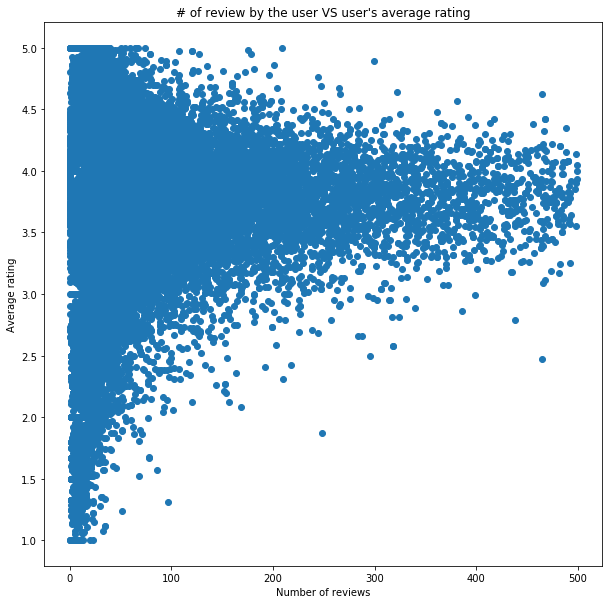

In [253]:
plt.figure(figsize=(10,10))
plt.scatter(users2['review_count'], users2['average_stars'])
plt.xlabel('Number of reviews')
plt.ylabel('Average rating')
plt.title('# of review by the user VS user\'s average rating')
plt.show()

As can be seen above, people with more reviews tend to have a similar review average, making people with more reviews less bias and likely more accurate.

Lets take a small sample of businesses and normalize their reviews:

In [268]:
bus = businessSampler.getSample(1000).dropna()
bus.rename(columns={'stars':'bus_stars'}, inplace=True)
#bus.head(3)

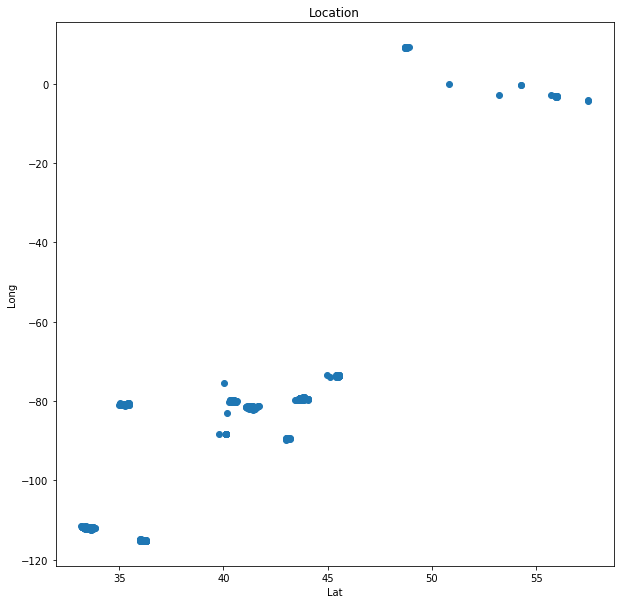

In [269]:
plt.figure(figsize=(10,10))
plt.scatter(bus['latitude'], bus['longitude'])
plt.xlabel('Lat')
plt.ylabel('Long')
plt.title('Location')
plt.show()

Above is a graphical representation for fun of the physical location of the businesses that we have selected, shows by by latitude and longitude.

In [270]:
#now we merge the businesses, all their cooresponding reviews in the data, and the user information that belongs with those reviews
bus_adv = pd.merge(bus, reviews_raw, on='business_id')
bus_adv = pd.merge(bus_adv, users, on='user_id')
#bus_adv.describe()

In [276]:
bus_adv.head(3)

,business_id,name_x,city,state,postal_code,latitude,longitude,bus_stars,review_count_x,is_open,categories,user_id,stars,name_y,review_count_y,yelping_since,average_stars,user_weight
0,Xbxsy9dKywU3iVe3ME9fqw,"""SharKlean Residential Cleaning""",Charlotte,NC,28210,35.127429,-80.859919,3.5,3,0,Home Services;Home Cleaning,jNK_TnjK7sqXPS8Vfs6mbQ,5,Addy,3,2014-04-09,5.00,1.03
1,Xbxsy9dKywU3iVe3ME9fqw,"""SharKlean Residential Cleaning""",Charlotte,NC,28210,35.127429,-80.859919,3.5,3,0,Home Services;Home Cleaning,vILOD03iU72N5NsfpsYI9g,1,Kristen,1,2016-04-30,1.00,1.01
2,Xbxsy9dKywU3iVe3ME9fqw,"""SharKlean Residential Cleaning""",Charlotte,NC,28210,35.127429,-80.859919,3.5,3,0,Home Services;Home Cleaning,PJcIgB_gYuB9jgyDROLBHw,5,Tony,30,2015-06-06,3.77,1.30


In [284]:
old_adv1 = []
for item in bus['business_id']:
    adv1 = bus_adv[bus_adv['business_id'] == item]['stars'].mean()
    
    summ = 0
    reviews = 0.0
    for index, row in bus_adv[bus_adv['business_id'] == item].iterrows():
        user_num_rev = row['review_count_y']
        weight = 1.0
        if (user_num_rev > 50):
            #for every review they have over 50, their weight increases by 0.1
            weight = 1.0 + 0.01 * (user_num_rev - 50.0)
        summ = summ + row['stars'] * weight
        reviews = reviews + weight
    old_adv1.append([item, adv1, summ / reviews, adv1-summ/reviews])
old_adv = pd.DataFrame(old_adv1, columns=['business_id', 'reg_adv', 'new_adv', 'diff'])

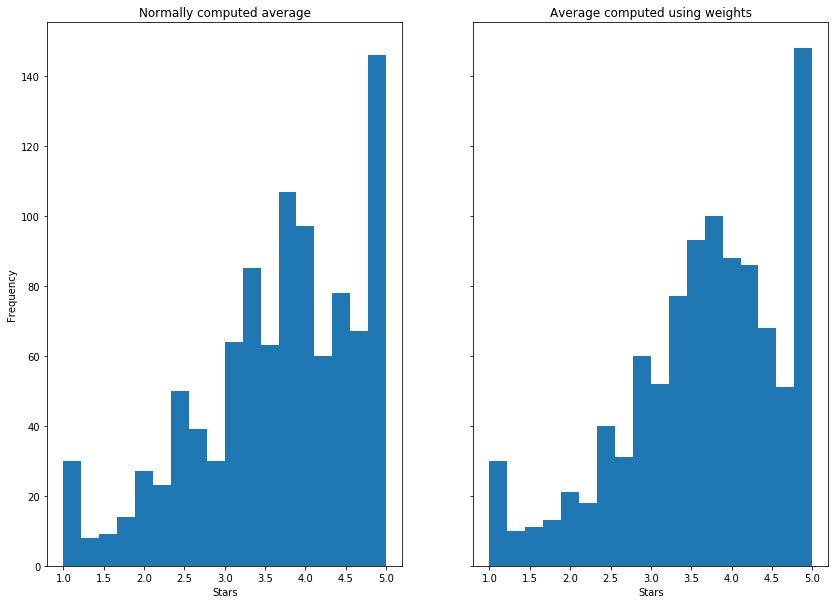

In [279]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,10))
axs[0].hist(old_adv['reg_adv'], bins = 18)
axs[1].hist(old_adv['new_adv'], bins = 18)
#plt.set_xlabel('Stars')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('Stars')
axs[0].set_xlabel('Stars')
axs[0].set_title('Normally computed average')
axs[1].set_title('Average computed using weights')
plt.show()

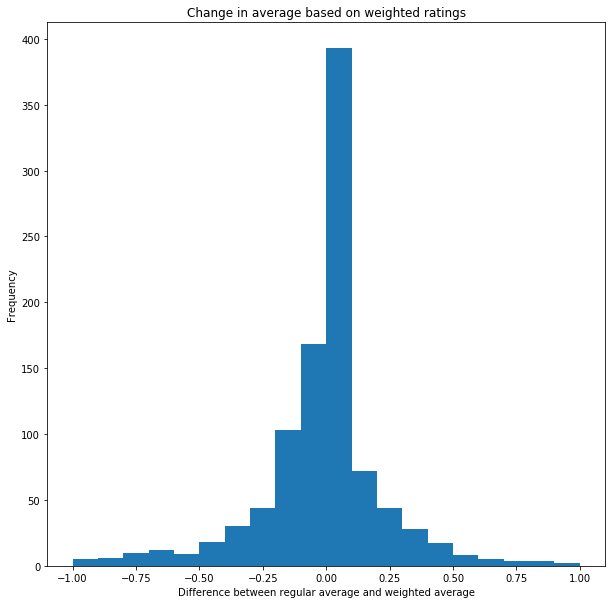

In [287]:
plt.figure(figsize=(10,10))
plt.hist(old_adv['diff'], range=(-1,1), bins=20)
plt.xlabel('Difference between regular average and weighted average')
plt.ylabel('Frequency')
plt.title('Change in average based on weighted ratings')
plt.show()

The graph above takes into account average star rating of a business and the start rating if you give more weight to people who have made more reviews.

In [216]:
norm_bus1 = []
#true mean of all reviews in dataset
adv_stars_all = 3.72770311158596
for item in bus['business_id']:
    adv1 = bus_adv[bus_adv['business_id'] == item]['stars'].mean()
    
    summ = 0.0
    reviews = 0.0
    for index, row in bus_adv[bus_adv['business_id'] == item].iterrows():
        diff = adv_stars_all - row['average_stars']
        summ = summ + row['stars'] + diff
        reviews = reviews + 1
    
    norm_bus1.append([item, adv1, summ / reviews, adv1-summ/reviews])
norm_bus = pd.DataFrame(norm_bus1, columns=['business_id', 'reg_adv', 'new_adv', 'diff'])

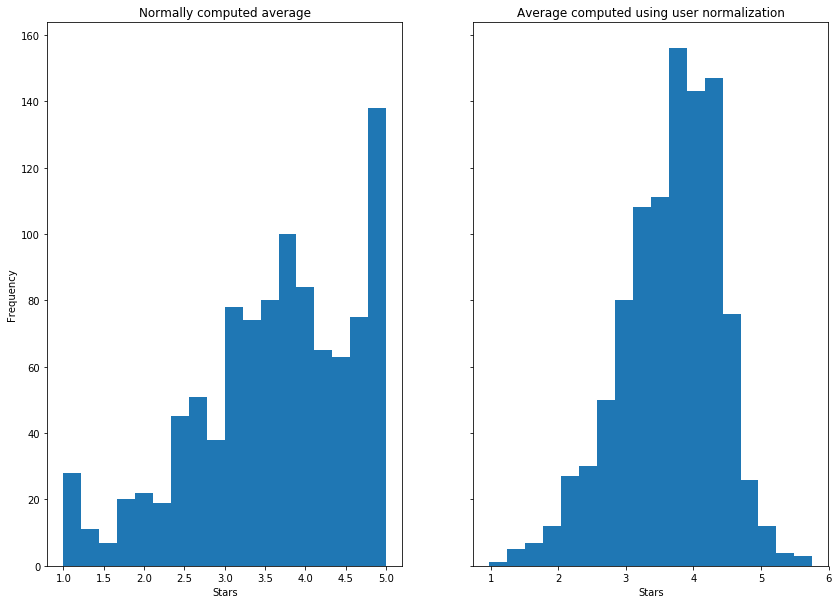

In [288]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,10))
axs[0].hist(norm_bus['reg_adv'], bins = 18)
axs[1].hist(norm_bus['new_adv'], bins = 18)
#plt.set_xlabel('Stars')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('Stars')
axs[0].set_xlabel('Stars')
axs[0].set_title('Normally computed average')
axs[1].set_title('Average computed using user normalization')
plt.show()

As is shown from the histograms, we have normalized the ratings for these businesses around the average rating for the entire dataset.

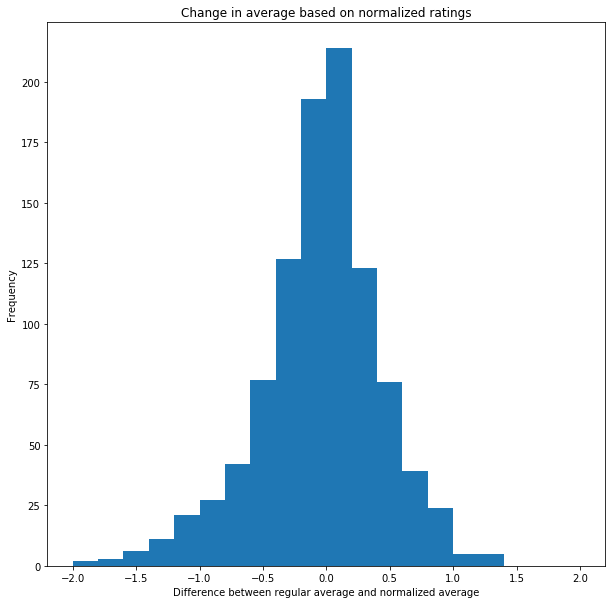

In [286]:
plt.figure(figsize=(10,10))
plt.hist(norm_bus['diff'], range=(-2,2), bins=20)
plt.xlabel('Difference between regular average and normalized average')
plt.ylabel('Frequency')
plt.title('Change in average based on normalized ratings')
plt.show()

The graph above takes into account average star rating of a business and the start rating if you normalize every review based on the average review stars on the user.